In [1]:
# This has just a PFC and sensory-motor system only, with the PFC as a LSTM. Does not have an MD yet.

# I am going to start by adding a delay period here: we'll have it ignore all but the last cue before the delay,
# then act appropriately after the delay

# This should be a much harder task...

In [2]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
%matplotlib inline

/Users/adammarblestone/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
# Parameters of the network
num_units_PFC = 40
num_hidden_sensorymotor = 20
num_timesteps = 15

# Parameters of the training
batch_size = 8
num_batches = 2000
learning_rate = 0.01

# Parameters of the delay task
start_time_of_delay = 5
end_time_of_delay = 10

In [4]:
# DEFINITION OF THE TASK

# The "rule input" to the sensory motor system, coming from PFC, currently takes the form of just a number, either 1.0 or 2.0
# 1.0 indicates to use vision and ignore audition, and 2.0 indicates to use audition and ignore vision
def rvis(): 
    return 1.0 # If the input to the sensory-motor system, x, has 1 <= x < 2 then use vision
def raud(): # If the input to the sensory-motor system, x, has x > 2 then use audition
    return 2.0
def rnull(): # We'll use rnull output to indicate waiting during the delay period
    return 0.0

# This is the function that will be used to evaluate whether the PFC outputs the correct rule for a given cue, and to train it to do so
def cue_to_rule_mapping_function(t, integer_input): # Define a changing mapping from cues to rules
    
    if t >= end_time_of_delay: # We can use this type of conditioning to set up time-dependent cue-to-rule mappings
        
        r1 = tf.cond(tf.equal(integer_input, tf.constant(0, dtype = tf.float32)), true_fn = rvis, false_fn = rnull)
    
        r2 = tf.cond(tf.equal(integer_input, tf.constant(1, dtype = tf.float32)), true_fn = rvis, false_fn = rnull)
        
        r3 = tf.cond(tf.equal(integer_input, tf.constant(2, dtype = tf.float32)), true_fn = raud, false_fn = rnull)
        
        r4 = tf.cond(tf.equal(integer_input, tf.constant(3, dtype = tf.float32)), true_fn = raud, false_fn = rnull) 
    
        return tf.reduce_max([r1,r2,r3,r4])
    
    else:
        
        return tf.constant(rnull(), dtype=tf.float32)
        

In [5]:
# Function for evaluating correctness
def correctness(q, o, ina, inv, ctin): # Arguments: time, PFC output list, auditory input list, vision input list, cue inputs timeline
    
    if q >= end_time_of_delay: # In this case, should be executing a rule
    
        c = []
        for e in range(batch_size):
            if (np.linalg.norm(inv[e,q] - o[q][e]) < np.linalg.norm(ina[e,q] - o[q][e]) and sess.run(cue_to_rule_mapping_function(q, float(ctin[e,start_time_of_delay-1]))) == 1.0):
                c.append("correct") # If the output coordinates are closer to the vision target than the auditory target and that's the right rule
            elif (np.linalg.norm(inv[e,q] - o[q][e]) > np.linalg.norm(ina[e,q] - o[q][e]) and sess.run(cue_to_rule_mapping_function(q, float(ctin[e,start_time_of_delay-1]))) == 2.0):
                c.append("correct") # If the output coordinates are closer to the auditory target than the vision target and that's the right rule
            else:
                c.append("incorrect")
        return c
    
    else: # In this case, should output something close to the origin coordinates (0,0)
        c = []
        for e in range(batch_size):
            if np.linalg.norm([0.0,0.0] - o[q][e]) < 0.001:
                c.append("correct")
            else:
                c.append("incorrect")
        return c

Loss: 17.020468



timestep 0
out [[ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]] 
vis in [[ 0.05175337  0.56325748]
 [ 0.08119608  0.09386139]
 [ 0.0858814   0.47248205]
 [ 0.08938793  0.37175956]
 [ 0.13712844  0.01358585]
 [ 0.15556277  0.72515566]
 [ 0.81922035  0.02428192]
 [ 0.86086337  0.68517103]] 
aud in [[ 0.86809389  0.33326082]
 [ 0.86855123  0.3100536 ]
 [ 0.10482323  0.87648768]
 [ 0.36208114  0.97979582]
 [ 0.94152118  0.43885425]
 [ 0.60978645  0.06203078]
 [ 0.21716818  0.00442   ]
 [ 0.24814753  0.05980349]] 
rule chosen [[-0.0942012 ]
 [-0.1183072 ]
 [-0.10968515]
 [-0.0942012 ]
 [-0.0942012 ]
 [-0.1183072 ]
 [-0.10968515]
 [-0.0942012 ]]
rule specified by cue just prior to the delay period: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
correctness: ['correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct']


timestep 1
out [[ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [

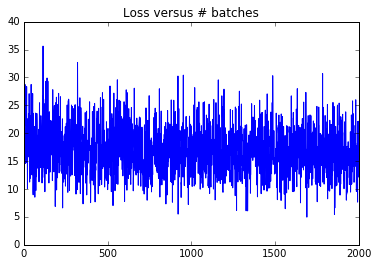

In [6]:
# Define the network

DO_SHARE = None # This is needed for the recurrency of the RNN, see: https://blog.evjang.com/2016/06/understanding-and-implementing.html

PFC_state_previous = tf.contrib.rnn.LSTMBlockCell(num_units = num_units_PFC).zero_state(batch_size, tf.float32) # Initial state of PFC

# This does one cycle of the PFC RNN
def PFC_step(input_data, network_state):
    with tf.variable_scope("PFC", reuse=DO_SHARE):
        PFC_cell = tf.contrib.rnn.LSTMBlockCell(num_units = num_units_PFC)
        return PFC_cell(inputs = input_data, state = network_state) 
    
# Cue inputs delivered INTO the PFC, e.g., high pass noise, UV light, and so forth, here defined currently as just an integer indiciating which cue
cue_timeseries = tf.placeholder(shape=[batch_size, num_timesteps, 1], dtype=tf.float32, name = 'cues_timeseries')

# Visual and audio targets input to the sensory-motor system, represented as just 2D coordinates, one for each, right now
input_vis = tf.placeholder(shape=[batch_size, num_timesteps, 2], dtype=tf.float32, name = 'input_vis')
input_aud = tf.placeholder(shape=[batch_size, num_timesteps, 2], dtype=tf.float32, name = 'input_aud')

loss = 0 # This will accumulate contributions to the loss function
outs = [] # Output coordinates from the sensory-motor system
rules_chosen = [] # Rules input from the PFC to the sensory-motor system

pre_delay_cue = cue_timeseries[:,start_time_of_delay - 1]

for t in range(num_timesteps): # Iterating over time in the experiment, with batches implicitly being used at each time step
    
    current_cue = cue_timeseries[:,t] # This is the cue that gets fed into the PFC on this timestep

    PFC_state = PFC_step(input_data = current_cue, network_state = PFC_state_previous)
    # The output from the PFC into the sensorymotor system gives information about the rule that the sensory-motor system is supposed to execute
    with tf.variable_scope("PFC_output", reuse=DO_SHARE):
        PFC_output = tf.contrib.layers.fully_connected(PFC_state[0], 1, activation_fn = None) # Note the 1-dimensional rule output; also this layer is linear
    rules_chosen.append(PFC_output) # The info sent by PFC to the sensory-motor system, corresponding to the chosen rule

    input_rule_to_sensorymotor_system = PFC_output # The rule output from the PFC is sent to the sensory-motor system
    input_total = tf.concat([input_vis[:,t], input_aud[:,t], input_rule_to_sensorymotor_system], axis = -1) # Sensory-motor system gets aud, vis & rule inputs
    
    with tf.variable_scope("hidden_sensorymotor", reuse=DO_SHARE):
        hidden_sensorymotor = tf.contrib.layers.fully_connected(input_total, num_hidden_sensorymotor, activation_fn = tf.nn.relu) # Sensory-motor hidden layer
    
    num_out_sensorymotor = 2 # These are the 2D coordinates that we want to sensory-motor system to produce
    
    with tf.variable_scope("out_sensorymotor", reuse=DO_SHARE):
        out_sensorymotor = tf.contrib.layers.fully_connected(hidden_sensorymotor, num_out_sensorymotor, activation_fn = tf.nn.relu) 
        # Output coord from sensory-motor system
    
    outs.append(out_sensorymotor)
    
    PFC_state_previous = PFC_state[1] # This is needed for the recurrency of the PFC RNN
    
    for e in range(batch_size): # Here is where we compute a contribution to the loss function for training
        cpred = pre_delay_cue[e][0] # The cue we are supposed to be holding on to in working memory
        cue_to_rule_mapping_function_output = cue_to_rule_mapping_function(t, cpred) # The CORRECT rule to choose in the task
        if t >= end_time_of_delay: # We use this to set up time-dependent loss functions, e.g., only look at late times
            loss_contrib1 = tf.cond(tf.equal(cue_to_rule_mapping_function_output, tf.constant(1, dtype = tf.float32)),\
                                    true_fn = lambda: tf.square(tf.norm(input_vis[e,start_time_of_delay-1] - out_sensorymotor[e])),  false_fn = lambda: 0.0)
            loss_contrib2 = tf.cond(tf.equal(cue_to_rule_mapping_function_output, tf.constant(2, dtype = tf.float32)),\
                                    true_fn = lambda: tf.square(tf.norm(input_aud[e,start_time_of_delay-1] - out_sensorymotor[e])),  false_fn = lambda: 0.0)
            # The last two lines define the loss function contribution at a given time, 
            # here the proximity of the output coordinate to the visual input target OR the proximity to the auditory target,
            # depending on the correct rule for this moment in the task
            loss += (loss_contrib1 + loss_contrib2)
        else:
            loss += tf.reduce_sum(tf.square(out_sensorymotor[e])) # Distance of the output from the origin...
            
    DO_SHARE = True # This is needed for the recurrency of the RNN, see: https://blog.evjang.com/2016/06/understanding-and-implementing.html

# Setting up the session
optimizer = tf.train.AdamOptimizer(learning_rate)
train_op=optimizer.minimize(loss)
sess = tf.Session()
sess.run(tf.initialize_all_variables())

# This is the cue timeseries input provided by the environment
# Here random cues are delivered across time and within batch
ct = np.reshape([np.random.randint(0,4) for k in range(num_timesteps * batch_size * num_batches)], [num_batches, batch_size, num_timesteps, 1])
    
# Randomly chosen visual target coordinates
in_vis_list_unshaped = [[np.random.rand(), np.random.rand()] for k in range(num_timesteps * batch_size * num_batches)] 
in_vis_list = np.reshape(in_vis_list_unshaped, [num_batches,batch_size,num_timesteps, 2])

# Randomly chosen auditory target coordinates
in_aud_list_unshaped = [[np.random.rand(), np.random.rand()] for k in range(num_timesteps * batch_size * num_batches)]
in_aud_list = np.reshape(in_aud_list_unshaped, [num_batches,batch_size,num_timesteps, 2])

# Running the session and storing the loss function across batches to see the learning curve  
losses = []
for b in range(num_batches): # Running the training batches
    ct_in = ct[b, :, :]
    in_v = in_vis_list[b, :, :]
    in_a = in_aud_list[b, :, :]
    os, l, rc, _ = sess.run([outs, loss, rules_chosen, train_op], feed_dict = {cue_timeseries:ct_in, input_vis: in_v, input_aud:in_a})
    # The outputs here are just for the last batch only...
    losses.append(l)
                        
# Printing the outputs for visual inspection
print "Loss: %f" % l
print "\n\n"
for q in range(num_timesteps):
    print "timestep %i" % q
    print "out", os[q][:], "\n", "vis in", in_v[:,q],"\n", "aud in", in_a[:, q],"\n", "PFC output", rc[q][:] 
    print "rule given cue just prior to delay period:", [sess.run(cue_to_rule_mapping_function(q, float(ct_in[e,start_time_of_delay-1]))) for e in range(batch_size)] 
    print "correctness:", correctness(q, os, in_a, in_v, ct_in) 
    print "\n"

# Plotting the loss function over time to see the learning process
plt.figure()
plt.plot(losses)
plt.title("Loss versus # batches")
plt.show()